In [41]:
# Necessary imports
%load_ext autoreload
%autoreload 2\

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import the TCGA cancer data

In [42]:
folder_path = "/home/jonny_admin/PycharmProjects/TCGA-Assembler/BRCA/"
external_data_path = "/home/jonny_admin/PycharmProjects/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="BRCA", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
#                                        "GE",
#                                        "MIR",
#                                        "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

# luad_data.GE.drop_genes(set(luad_data.GE.get_genes_list()) & set(luad_data.LNC.get_genes_list()))

PATIENTS (1097, 112)
DRUGS (2406, 4)


In [43]:
luad_data.clinical.patient

,bcr_patient_uuid,bcr_patient_barcode,form_completion_date,prospective_collection,retrospective_collection,birth_days_to,gender,menopause_status,race,ethnicity,...,icd_o_3_histology,icd_o_3_site,informed_consent_verified,metastatic_tumor_indicator,patient_id,project_code,site_of_primary_tumor_other,stage_other,tissue_source_site,tumor_tissue_site
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,2014-1-13,NO,YES,-20211.0,FEMALE,Pre (<6 months since LMP AND no prior bilatera...,WHITE,NOT HISPANIC OR LATINO,...,8520/3,C50.9,YES,NaN,AAAU,NaN,NaN,NaN,3C,Breast
TCGA-3C-AALI,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,2014-7-28,NO,YES,-18538.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,8500/3,C50.9,YES,NaN,AALI,NaN,NaN,NaN,3C,Breast
TCGA-3C-AALJ,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,2014-7-28,NO,YES,-22848.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,8500/3,C50.9,YES,NaN,AALJ,NaN,NaN,NaN,3C,Breast
TCGA-3C-AALK,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,2014-7-28,NO,YES,-19074.0,FEMALE,[Unknown],BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,8500/3,C50.9,YES,NaN,AALK,NaN,NaN,NaN,3C,Breast
TCGA-4H-AAAK,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,2014-11-13,YES,NO,-18371.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,...,8520/3,C50.9,YES,NaN,AAAK,NaN,NaN,NaN,4H,Breast
TCGA-5L-AAT0,86C6F993-327F-4525-9983-29C55625593A,TCGA-5L-AAT0,2014-8-15,NO,YES,-15393.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,HISPANIC OR LATINO,...,8520/3,C50.9,YES,NaN,AAT0,NaN,NaN,NaN,5L,Breast
TCGA-5L-AAT1,16FC3677-0393-4ED1-AD3F-C8355F056369,TCGA-5L-AAT1,2014-8-15,NO,YES,-23225.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,HISPANIC OR LATINO,...,8520/3,C50.9,YES,NaN,AAT1,NaN,NaN,NaN,5L,Breast
TCGA-5T-A9QA,2FD36838-5A83-433E-AC80-B1F77448E5AA,TCGA-5T-A9QA,2013-12-23,YES,NO,-19031.0,FEMALE,[Unknown],BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,...,8523/3,C50.9,YES,NaN,A9QA,NaN,NaN,NaN,5T,Breast
TCGA-A1-A0SB,0045349c-69d9-4306-a403-c9c1fa836644,TCGA-A1-A0SB,2011-6-30,NO,YES,-25833.0,FEMALE,Post (prior bilateral ovariectomy OR >12 mo si...,WHITE,NOT HISPANIC OR LATINO,...,8200/3,C50.9,YES,NO,A0SB,NaN,NaN,NaN,A1,Breast


# Heterogeneous Network

In [4]:
from moge.network.heterogeneous_network import HeterogeneousNetwork
from moge.utils.omics_distance import compute_expression_correlations, compute_annotation_similarity
network = HeterogeneousNetwork(modalities=["MIR", "GE"], multi_omics_data=luad_data)


MIR  nodes: 1870
GE  nodes: 20472
Total nodes: 22342


In [7]:
# READ Edgeslist
network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
                             directed=False)
network.import_edgelist_file(file="moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
                             directed=True)

In [20]:
# WRITE Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_99_50.edgelist", 
#                   data=True)

# nx.write_edgelist(network.get_subgraph(["MIR", "GE"]), 
#                   "moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_regulatory_interactions.edgelist", 
#                   data=True)

In [2]:
import pickle

# with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'wb') as file:
#     pickle.dump(network, file)

with open('moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_network.pickle', 'rb') as file:
    network = pickle.load(file)

#### Write node labels to file

In [24]:
from moge.utils.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_labels_disease.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE"], remove_na=True, sep="\t",
#                           get_dummies=False)

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:526: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


# Add Node Similarity Edges

In [4]:
network.add_edges_from_nodes_similarity(modality="GE", similarity_threshold=0.99, features=["locus_type", "gene_family_id"])

Gower's dissimilarity: Computing locus_type
Gower's dissimilarity: Computing gene_family_id


/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/utils/omics_distance.py:85: RuntimeWarning: Mean of empty slice
  pdists_mean = np.nanmean(np.array(individual_variable_distances), axis=0)


11815196 edges added.


In [5]:
network.add_edges_from_nodes_similarity(modality="MIR", similarity_threshold=0.5)

Gower's dissimilarity: Computing miR family


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:528: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  gene_info = gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID",how="left")


Gower's dissimilarity: Computing Mature sequence
1038 edges added.


/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/utils/omics_distance.py:85: RuntimeWarning: Mean of empty slice
  pdists_mean = np.nanmean(np.array(individual_variable_distances), axis=0)


In [ ]:
network.add_edges_from_nodes_similarity(modality="LNC", similarity_threshold=0.99, features=["Transcript Type"])

In [16]:
adj_similarity = nx.adjacency_matrix(network.get_subgraph(["MIR", "GE"]), nodelist=network.all_nodes)
adj_similarity

<22154x22154 sparse matrix of type '<class 'numpy.float64'>'
	with 11769888 stored elements in Compressed Sparse Row format>

##### Save/Load to file

In [42]:
np.save("moge/data/lncRNA_miRNA_mRNA/adj_similarity_MIR_GE.npy", adj_similarity)

In [39]:
network.add_edges_from_edgelist(nx.read_edgelist("moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_node_similarity_e99_e5.edgelist", 
                                                 create_using=nx.Graph()).edges(data=True))

Adding edgelist with 19637 total unique GE genes (source), but only matching 10799 nodes
Adding edgelist with 19741 total unique GE genes (target), but only matching 10892 nodes


# Add Regulatory Interaction edges

In [14]:
# Adds miRNA-target interaction network
network.add_edges_from_edgelist(edgelist=luad_data.MIR.get_miRNA_target_interaction_edgelist(), 
                                modalities=["MIR", "GE"])

Adding edgelist with 284 total unique MIR genes (source), but only matching 247 nodes
Adding edgelist with 13035 total unique GE genes (target), but only matching 12234 nodes
198312 edges added.


In [15]:
# Adds Gene Regulatory Network edges
network.add_edges_from_edgelist(edgelist=luad_data.GE.get_RegNet_GRN_edgelist(),
                               modalities=["GE", "GE"])

Adding edgelist with 2072 total unique GE genes (source), but only matching 1426 nodes
Adding edgelist with 23158 total unique GE genes (target), but only matching 17694 nodes
371501 edges added.


In [ ]:
# Adds miRNA-lncRNA interaction network
network.add_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
                               modalities=["LNC", "MIR"])
network.add_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
                               modalities=["LNC", "MIR"])

In [ ]:
network.remove_isolates()

##### Save/Load to file

In [6]:
adj_regulatory = nx.adjacency_matrix(network.get_subgraph(["MIR", "GE"]), nodelist=network.all_nodes)

In [11]:
adj_regulatory

<22342x22342 sparse matrix of type '<class 'numpy.float64'>'
	with 357199 stored elements in Compressed Sparse Row format>

In [47]:
np.save("moge/data/lncRNA_miRNA_mRNA/adj_regulatory_MIR_GE.npy", adj_similarity)

# Add Correlation edges

In [ ]:
mir_ge_corr = network.compute_multiomics_correlations(modalities=["MIR", "GE"])

## Network Info & Visualizations

In [23]:
print("isolated nodes:", len(nx.isolates(network.get_subgraph(modalities=["MIR", "GE"]))),
      ", out of total nodes:", network.all_nodes.__len__())
print("edges: ", network.get_subgraph(modalities=["MIR", "GE"]).number_of_edges())

isolated nodes: 1988 , out of total nodes: 22342
edges:  12171466


In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))
# print(luad_data.LNC.get_genes_list())

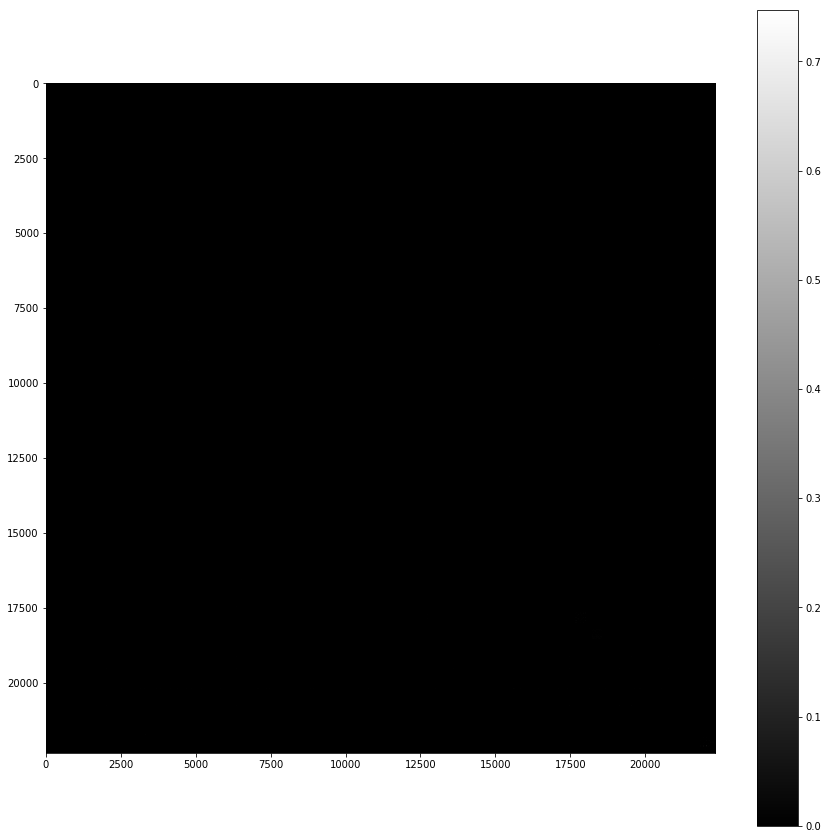

In [8]:
# Scatter plot of original graph adjacency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(graph_emb.get_reconstructed_adj(edge_type="u"), interpolation='none', cmap=plt.cm.gray)
plt.colorbar()
plt.show()

# Laplacian Matrix

In [27]:
# G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.Graph())


/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/opt/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


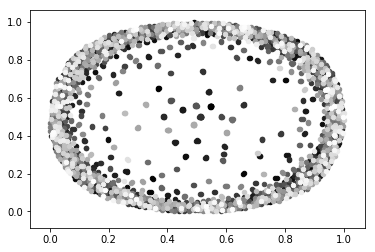

In [28]:
import community

partition = community.best_partition(network.G.to_undirected())
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
# Scatter plot of original graph adjacency matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(U, interpolation='none', cmap=plt.cm.bwr)
plt.colorbar()
plt.show()

In [9]:
len([k for k, v in network.G.degree_iter() if v > 0])

20354

# Training Source Target Graph Embedding

In [4]:
from moge.embedding.dual_graph_embedding import SourceTargetGraphEmbedding

graph_emb = SourceTargetGraphEmbedding(d=64, lr=0.1, Ed_Eu_ratio=None, epochs=5, batch_size=100000)
# graph_emb.learn_embedding(network, seed=1)


In [81]:
network.get_adjacency_matrix()[network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7c')]

0.9772727272727273

In [83]:
graph_emb.get_edge_weight(network.all_nodes.index('hsa-let-7b'), network.all_nodes.index('hsa-let-7e'), edge_type="u")

4.1358504e-08

In [5]:
graph_emb.import_embedding("/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/data/lncRNA_miRNA_mRNA/miRNA-mRNA_source_target_embeddings_128.embeddings",
                          node_list=network.all_nodes)

# graph_emb.save_embeddings("miRNA-mRNA_source_target_embeddings_128.embeddings")

# Import different models

In [60]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/miRNA-mRNA_LINE.txt", 
                          node_list=network.all_nodes)

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt", 
                          node_list=network.all_nodes)

node_list = list(set(line_emb.node_list) & set(node2vec_emb.node_list))

[autoreload of moge.evaluation.utils failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/opt/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/jonny_admin/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py", line 16, in <module>
    def split_graph_train_test(network:HeterogeneousNetwork, ):
NameError: name 'Heter

In [61]:
models = []
models.append(graph_emb)
models.append(line_emb)
models.append(node2vec_emb)

# Evaluate Source Target Graph Embeddings

In [62]:
from moge.evaluation.evaluate_graph_reconstruction import evaluateStaticGraphReconstruction

for model in models:
    print("\n",model.get_method_name())
    norm = evaluateStaticGraphReconstruction(network, model, edge_type="u", sample_ratio=1.0, 
                                             node_list=node_list)
    print(norm)


 source_target_graph_embedding
Sampling 9931984 edges to be evaluated.
0.0003173018401787234

 LINE
Sampling 9931984 edges to be evaluated.
0.00011889353738678541

 node2vec
Sampling 9931984 edges to be evaluated.
0.0012925343647035483


# Import GEM Graph Embedding Methods

In [51]:
import matplotlib.pyplot as plt
import networkx as nx

from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr
from gem.evaluation.metrics import getPrecisionReport
from gem.evaluation.evaluate_link_prediction import evaluateStaticLinkPrediction

from time import time

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne     import SDNE
from moge.embedding.dual_graph_embedding import DualGraphEmbedding


# File that contains the edges. Format: source target
# Optionally, you can add weights as third column: source target weight

# Specify whether the edges are directed
isDirected = True

# Load graph
# G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=isDirected)
# G = G.to_directed()

# G = nx.read_edgelist('../nuclei-segmentation/notebooks/gem/data/ppi.edgelist', create_using=nx.DiGraph())
# G = nx.read_edgelist('moge/data/karate.edgelist', create_using=nx.DiGraph())

G = network.G.to_directed()

G = nx.convert_node_labels_to_integers(G)

In [54]:
models = []
# You can comment out the methods you don't want to run
# models.append(HOPE(d=100, beta=0.1))
# models.append(GraphFactorization(d=200, max_iter=100, eta=1*10**-4, regu=1.0))
models.append(LaplacianEigenmaps(d=200))
models.append(LocallyLinearEmbedding(d=200))
# models.append(node2vec(d=200, max_iter=10, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1))
# models.append(SDNE(d=200, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, 
#                    K=3, n_units=[50, 15,], rho=0.3, 
#                    n_iter=100, xeta=0.01, n_batch=500))

# models.append(DualGraphEmbedding(d=100, reg=1.0, lr=0.05, iterations=100))
                   

In [55]:
print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
for embedding in models:
    try:
        print("\n", embedding.get_method_name(), embedding.get_method_summary())
        t1 = time()
        
    #     Learn embedding - accepts a networkx graph or file with edge list
        embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
        print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))

        Y = embedding.get_embedding()

#         # Evaluate on graph reconstruction
        MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, 
                                                                                 sample_ratio_e=0.0001, k=500000)
        print ("Graph Reconstruction. MAP:", MAP)

        
        # Evaluate on link prediction
#         MAP, prec_curv = evaluateStaticLinkPrediction(G, embedding,
#                                      train_ratio=0.8,
#                                      is_undirected=False)
#         print ("Link Prediction. MAP:", MAP)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
        
        # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
    except Exception as e:
        print("could not run", embedding, e)

Num nodes: 23179, num edges: 199324

 lap_eigmap_svd lap_eigmap_svd_200
Laplacian matrix recon. error (low rank): 118.058668
lap_eigmap_svd:
	Training time: 156.647702


KeyboardInterrupt: 

# Plot Adjacency Matrix

In [8]:
def load_embeddings(filename):
    fin = open(filename, 'r')
    node_num, size = [int(x) for x in fin.readline().strip().split()]
    vectors = {} 
    while 1:
        l = fin.readline()
        if l == '':
            break
        vec = l.strip().split(' ')
        assert len(vec) == size+1
        vectors[vec[0]] = [float(x) for x in vec[1:]]
    fin.close()
    assert len(vectors) == node_num
    return vectors

In [9]:
mir_ge_node2vec = load_embeddings("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_node2vec.txt")

In [14]:
mir_ge_line = load_embeddings("/home/jonny_admin/PycharmProjects/OpenNE/vec_all_LINE.txt")

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2)
node_pos = model.fit_transform(models[0].get_embedding())
pos = {}
for i in range(len(G.nodes())):
    pos[i] = node_pos[i, :]
nx.draw_networkx(G, pos, width=0.1, node_size=300, arrows=False,
                             alpha=0.8, font_size=12)